<a href="https://colab.research.google.com/github/JohnnyWang1998/Conversion_rate_prediction/blob/main/Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
from typing import List
from matplotlib import pyplot as plt
import plotly.express as px

In [48]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,recall_score,precision_score,f1_score, ConfusionMatrixDisplay, log_loss
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

In [ ]:
import lightgbm as lgb
import xgboost as xgb

In [3]:
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [31]:
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Activation, Dense, Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras import regularizers
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [6]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/train.csv')

Mounted at /content/drive


# Modeling

## Data Preprocessing

In [7]:
class DataModeler:
    def __init__(self):
        pass

    def _parametrized(dec):
        def layer(*args, **kwargs):
            def repl(f):
                return dec(f, *args, **kwargs)
            return repl
        return layer

    @staticmethod
    @_parametrized
    def logger(f, job):
        def aux(self, *xs, **kws):
            print(job + "...", end='\t')
            res = f(self, *xs, **kws) 
            print("Done")
            return res
        return aux

In [8]:
class DataPreprocessor(DataModeler):
    """Class to preprocess the data"""
    
    def __init__(self):
        super(DataPreprocessor, self).__init__()

    @DataModeler.logger("Filling missing value")
    def _fill_missing_value(self, df:pd.DataFrame) -> pd.DataFrame:
        """Fill missing values in input data"""
        res = df.copy()
        # na imputation
        numeric_cols = res.select_dtypes(include= np.number).columns
        imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
        imputer = imputer.fit(res[numeric_cols].values)
        
        res[numeric_cols] = imputer.transform(res[numeric_cols].values)
        return res
    
    @DataModeler.logger("Replacing outliers")
    def _replace_outliers(self, df:pd.DataFrame) -> pd.DataFrame:
        res = df.copy()
        return res

    @DataModeler.logger("Transforming feature type")
    def _trans_feat_type(self, _df:pd.DataFrame) -> List[pd.DataFrame]:
        """Transform some features to the correct type"""

        # transfer wrranty to binary
        df = _df.copy()
        pattern_list=[]
        for i in df['warranty']:
          if(pd.isnull(i)):
            pattern_list.append(False)
          elif(any(char.isdigit() for char in i)):
            pattern=True
            pattern_list.append(pattern)
          else:
            pattern=False
            pattern_list.append(pattern)
        df['warranty']=pattern_list

        # transfer main picture to binary
        df['main_picture']=df['main_picture'].notnull()

        return df


    @DataModeler.logger("Drop useless columns data")
    def _drop_columns(self, _df:pd.DataFrame) -> pd.DataFrame:
        """ Feature selection"""

        df = _df.copy()
        cols_drop = ['accepts_mercadopago','category_id','site_id',
                     'domain_id','item_id','print_server_timestamp',
                     'date','deal_print_id','etl_version','user_id',
                     'full_name','listing_type_id','platform','product_id',
                     'title','benefit','boosted','is_pdp', 'uid']
        df = df.drop(cols_drop, axis=1)
        return df
    
    def preprocess(self, _df:pd.DataFrame) -> pd.DataFrame:
        """Preprocess the data"""
        df = _df.copy()

        # drop useless and invalid columns
        df = self._drop_columns(df)

        # filling the na values
        df = self._fill_missing_value(df)

        # transfer feature types
        df = self._trans_feat_type(df)

        return df

In [9]:
data_preprocessor = DataPreprocessor()
df = data_preprocessor.preprocess(data)

Drop useless columns data...	Done
Filling missing value...	Done
Transforming feature type...	Done


## Feature Engineering

In [10]:
class FeatureEngineer(DataModeler):
    """Class to do the feature engineering"""
    
    def __init__(self):
        super(FeatureEngineer, self).__init__()
    
    @DataModeler.logger("One hot encoding")
    def _one_hot_encoding(self, _df:pd.DataFrame) -> pd.DataFrame:
        """One hot encoding"""

        df = _df.copy()

        # tags
        unique_tags_list=[]
        final_list=[]
        for i in df['tags']:
          unique_tags_list.append(i)
        for j in range(0,len(unique_tags_list)):
          unique_tags_list[j]=str(unique_tags_list[j][1:-1]).split(", ")
          final_list.append(unique_tags_list[j])
        flat_list = [item for sublist in final_list for item in sublist]
        flat_list=set(flat_list)
        for i in flat_list:
          new_col = []
          for j in df['tags']:
            if i in j:
              new_col.append(1)
            else:
              new_col.append(0)
          df[i] = new_col

        # logistic type
        value_list=[]
        for i in df['logistic_type']:
          if(i=='cross_docking'):
            pattern=1
            value_list.append(pattern)
          else:
            pattern=0
            value_list.append(pattern)
        df['cross_docking']=value_list
        val_list=[]
        for i in df['logistic_type']:
          if(i=='drop_off'):
            pattern=1
            val_list.append(pattern)
          else:
            pattern=0
            val_list.append(pattern)
        df['drop_off']=val_list

        return df

    @DataModeler.logger("Generating date features")
    def _generate_feats(self, _df:pd.DataFrame) -> pd.DataFrame:
        """Generate new features"""
        df = _df.copy()
        # discount column
        discount = (df["original_price"]-df["price"])/df["original_price"]
        df['discount'] = discount

        return df

    def engineering(self, _df:pd.DataFrame) -> pd.DataFrame:
        """Feature engineering process"""
        df = _df.copy()
        df = self._one_hot_encoding(df)
        df = self._generate_feats(df)
        # convert to float
        df *= 1
        return df
        

In [11]:
feat_engineer = FeatureEngineer()
df = feat_engineer.engineering(df)

One hot encoding...	Done
Generating date features...	Done


## Utils

In [55]:
def to_binary(y_test, y, threshold=None):
    if(threshold == None):
        thre, auc = best_threshold(y_test, y)
    else:
        thre = threshold
    x = y.copy()
    x[x>thre] = 1
    x[x<=thre] = 0
    return x

def best_threshold(y_test, pred):
    best_thre = -1
    best_auc = -1
    for i in tqdm(np.arange(0,0.5,0.001), "Finding the best threshold"):
        temp_loop = pred.copy()
        temp_loop[temp_loop>i] = 1
        temp_loop[temp_loop<=i] = 0
        current = f1_score(y_test, temp_loop)
        if(current > best_auc):
            best_auc = current
            best_thre = i
    return best_thre, best_auc

In [56]:
def performance(y_test, y_pred):
    auc = roc_auc_score(y_test, y_pred)
    recall = recall_score(y_test, to_binary(y_test, y_pred))
    print("\nAUC: {}".format(auc))
    print("Recall: {}".format(recall))

## Model Building

### Data split

In [13]:
df = df.reset_index(drop=True)
target = 'conversion'
drop_cols = ['tags','logistic_type','conversion']
features = [x for x in df.columns if x not in drop_cols]
df_train, df_test = train_test_split(df, test_size=0.20, random_state=42,stratify=df[target])
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [14]:
X_train = df_train[features]
y_train = df_train[target]
X_test = df_test[features]
y_test = df_test[target]
smote=SMOTE().fit(X_train,y_train)
df_X_sampled,df_y_sampled = smote.fit_resample(X_train,y_train)
df_train_sampled = pd.concat([df_X_sampled, df_y_sampled], axis=1)

In [73]:
class Learner(DataModeler):
    def __init__(self):
        super(Learner, self).__init__()

        self.model_dict = {
            'LR':    {'class':LogisticRegression,      'model':[]},
            'RF':    {'class':RandomForestClassifier, 'model':[]},
            'NB':   {'class':GaussianNB,            'model':[]},
            'LSVC':   {'class':LinearSVC,            'model':[]},
            'LGB':   {'class':None,                  'model':[]},
            'XGB':   {'class':None,                  'model':[]}
        }
    

    def train(self, df:pd.DataFrame, target:str, feats:List[str], nfold:int,
              model_name:str, model_param:dict, metric_func, return_pred_col=False):
        """
        Model training
        @param df: training data
        @param target: predicting target column name
        @param nfold: cross validation fold number
        @param feats: features to be used for training model
        @param model_name: model name, must be one of keys in model_dict
        @param model_param: model parameter dict
        @param metric_func: metric function
        @param return_pred_col: need to return predicted col or not
        """
        metric_l = []
        last_pred = np.array([])
        pred_col = np.array([])
        self.model_dict[model_name]['model'] = []

        for (trn_idx, val_idx) in tqdm(StratifiedKFold(nfold, shuffle=True, random_state=2021)
        .split(df[feats], df[target]), total=nfold, desc="Training", disable=False):
            train_x = df.loc[trn_idx, feats]
            train_y = df.loc[trn_idx, target]
            valid_x = df.loc[val_idx, feats]
            valid_y = df.loc[val_idx, target]
            if(model_name == 'LGB'):
                model, valid_pred = self._lgb_train(train_x, train_y, valid_x, valid_y, model_param)
            elif(model_name == 'XGB'):
                model, valid_pred = self._xgb_train(train_x, train_y, valid_x, valid_y, model_param)
            elif(model_name == "LSVC"):
                model = self.model_dict[model_name]['class'](**model_param).fit(train_x, train_y)
                valid_pred = model.predict(valid_x)
            else:
                model = self.model_dict[model_name]['class'](**model_param).fit(train_x, train_y)
                valid_pred = model.predict_proba(valid_x)[:,1]
            # valid prediction as a feature
            metric = metric_func(valid_y, valid_pred)
            metric_l.append(metric)
            if(last_pred.shape[0] != 0):
                pred_col = np.vstack((pred_col, valid_pred.reshape((-1,1))))
            else:
                last_pred = valid_pred.copy()
                pred_col = valid_pred.reshape(-1,1).copy()
            self.model_dict[model_name]['model'].append(model)
        print(f"{model_name} End of training, avg metric: {np.mean(metric_l)}")
        if return_pred_col== False:
            return np.mean(metric_l)
        else:
            return np.mean(metric_l), pred_col


    def _lgb_train(self, train_x:pd.DataFrame, train_y:pd.DataFrame,
                   valid_x:pd.DataFrame, valid_y:pd.DataFrame, params:dict):
        """
        LGB model training
        @param train_x: training data
        @param train_y: training target
        @param valid_x: validating data
        @param valid_y: validating target
        @param params: LGB model parameters
        """
        model = lgb.LGBMClassifier(
            class_weight="balanced",
            boosting_type='gbdt',
            num_leaves=params['num_leaves'],
            max_depth=params['max_depth'],
            learning_rate=params['learning_rate'],
            n_estimators=params['n_estimators']
        )
        model.fit(
            train_x, 
            train_y,
            verbose = 50, 
            eval_metric = "auc",
            eval_set = [(train_x, train_y), (valid_x, valid_y)], 
            early_stopping_rounds = 20
            )
        valid_pred = model.predict_proba(valid_x, num_iteration=model.best_iteration_)
        return model, valid_pred[:,1]

    def _xgb_train(self, train_x:pd.DataFrame, train_y:pd.DataFrame,
                   valid_x:pd.DataFrame, valid_y:pd.DataFrame, params:dict):
        """
        XGB model training
        @param train_x: training data
        @param train_y: training target
        @param valid_x: validating data
        @param valid_y: validating target
        @param params: LGB model parameters
        """
        model = xgb.XGBClassifier(
            objective="binary:logistic", 
            use_label_encoder=False, 
            **params
        )
        model.fit(
            train_x, 
            train_y,
            early_stopping_rounds=50,
            verbose = 50, 
            eval_metric = "auc",
            eval_set = [(train_x, train_y), (valid_x, valid_y)]
            )
        valid_pred = model.predict_proba(valid_x, ntree_limit=model.best_ntree_limit)
        return model, valid_pred[:,1]
    
    def _predict(self, df:pd.DataFrame, feats:List[str], model_name:str) -> np.array:
        """
        Use single model to predict
        @param df: testset
        @param feats: features used for training mdoel
        @param model_name: model name, must be one of keys in model_dict and has been trained
        return: prediction
        """
        pred_l = []

        # use all the models that has been generated in the cross validation part
        for model in self.model_dict[model_name]['model']:
            if model_name == 'LGB':
                pred_l.append(model.predict_proba(df[feats].values, num_iteration=model.best_iteration_)[:,1].tolist())
            elif model_name == 'XGB':
                pred_l.append(model.predict_proba(df[feats], ntree_limit=model.best_ntree_limit)[:,1].tolist())
            elif model_name == 'LSVC':
                pred_l.append(model.predict(df[feats].values).tolist())
            else:
                pred_l.append(model.predict_proba(df[feats].values)[:,1].tolist())

        pred = np.mean(np.array(pred_l), axis=0)
        return pred
    
    def predict(self, df:pd.DataFrame, feats:List[str], models=None) -> np.array:
        """
        Predicting the data by given models
        @param df: testset
        @param feats: features used for training mdoel
        @param models: list of model names to predict
        return: prediction
        """
        pred_l = []
        for model in tqdm(models, "Predicting"):
            tmp = self._predict(df, feats, model)
            pred_l.append(tmp.tolist())
        
        pred = np.mean(np.array(pred_l), axis=0)
        return pred

In [74]:
learner = Learner()

### Classical Models

#### Logistic Regression

In [96]:
param_lr = {
    'penalty':'l1', 
    'solver':'liblinear', 
    'class_weight':"balanced"
}
learner.train(df_train_sampled, target, features, 5, 'LR', param_lr, roc_auc_score)

Training: 100%|██████████| 5/5 [06:36<00:00, 79.32s/it]

LR End of training, avg metric: 0.7704505656990286


0.7704505656990286

In [97]:
pred_lr = learner.predict(df_test, features, ['LR'])

Predicting: 100%|██████████| 1/1 [00:00<00:00,  7.92it/s]


In [98]:
performance(y_test, pred_lr)

Finding the best threshold: 100%|██████████| 500/500 [00:10<00:00, 49.22it/s]


AUC: 0.68848676644718
Recall: 0.6324275903254702


#### Naive Bayes

In [99]:
learner.train(df_train_sampled, target, features, 5, 'NB', {}, roc_auc_score)

Training: 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]

NB End of training, avg metric: 0.6801568048943143


0.6801568048943143

In [100]:
pred_nb = learner.predict(df_test, features, ['NB'])

Predicting: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


In [101]:
performance(y_test, pred_nb)

Finding the best threshold: 100%|██████████| 500/500 [00:10<00:00, 48.69it/s]


AUC: 0.6638532072045195
Recall: 0.6115258286055539


#### Random Forest

In [102]:
param_rf = {
    'n_estimators':200, 
    'max_depth':5, 
    'class_weight':"balanced"
}
learner.train(df_train, target, features, 5, 'RF', param_rf, roc_auc_score)

Training: 100%|██████████| 5/5 [02:41<00:00, 32.26s/it]

RF End of training, avg metric: 0.7402564993074955


0.7402564993074955

In [103]:
pred_rf = learner.predict(df_test, features, ['RF'])

Predicting: 100%|██████████| 1/1 [00:03<00:00,  3.15s/it]


In [104]:
performance(y_test, pred_rf)

Finding the best threshold: 100%|██████████| 500/500 [00:09<00:00, 51.02it/s]


AUC: 0.7378324435815005
Recall: 0.7058823529411765


#### Linear SVC

In [105]:
param_lsvm = {
    'penalty':'l1',
    'dual':False, 
    'class_weight':'balanced'
}
learner.train(df_train, target, features, 5, 'LSVC', param_lsvm, roc_auc_score)

Training: 100%|██████████| 5/5 [01:43<00:00, 20.70s/it]

LSVC End of training, avg metric: 0.6551991584069483


0.6551991584069483

In [106]:
pred_lsvm = learner.predict(df_test, features, ['LSVC'])

Predicting: 100%|██████████| 1/1 [00:00<00:00,  8.40it/s]


In [107]:
performance(y_test, pred_lsvm)

Finding the best threshold: 100%|██████████| 500/500 [00:10<00:00, 46.71it/s]


AUC: 0.6613104119697293
Recall: 0.6434756643774261


### Boosters

#### XGB

In [75]:
param_xgb={
    'n_estimators':1000,
    'scale_pos_weight':10, 
    'subsample' : 0.8,
    'colsample_bytree': 0.8,
    'learning_rate': 0.09,
    'max_depth': 5
}
learner.train(df_train, target, features, 5, 'XGB', param_xgb, roc_auc_score)

Training:   0%|          | 0/5 [00:00<?, ?it/s]

[0]	validation_0-auc:0.727699	validation_1-auc:0.721868
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[50]	validation_0-auc:0.784293	validation_1-auc:0.758904
[100]	validation_0-auc:0.804503	validation_1-auc:0.764695
[150]	validation_0-auc:0.818812	validation_1-auc:0.768554
[200]	validation_0-auc:0.83047	validation_1-auc:0.771262
[250]	validation_0-auc:0.840177	validation_1-auc:0.772565
[300]	validation_0-auc:0.848928	validation_1-auc:0.773241
[350]	validation_0-auc:0.857256	validation_1-auc:0.774468
[400]	validation_0-auc:0.864293	validation_1-auc:0.775727
[450]	validation_0-auc:0.870371	validation_1-auc:0.776396
[500]	validation_0-auc:0.875796	validation_1-auc:0.775858
Stopping. Best iteration:
[456]	validation_0-auc:0.870802	validation_1-auc:0.776455



Training:  20%|██        | 1/5 [03:22<13:29, 202.30s/it]

[0]	validation_0-auc:0.725004	validation_1-auc:0.719063
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[50]	validation_0-auc:0.782501	validation_1-auc:0.763242
[100]	validation_0-auc:0.803325	validation_1-auc:0.770908
[150]	validation_0-auc:0.818093	validation_1-auc:0.773996
[200]	validation_0-auc:0.830628	validation_1-auc:0.775727
[250]	validation_0-auc:0.841395	validation_1-auc:0.776232
Stopping. Best iteration:
[216]	validation_0-auc:0.834464	validation_1-auc:0.776414



Training:  40%|████      | 2/5 [05:10<07:20, 146.68s/it]

[0]	validation_0-auc:0.728598	validation_1-auc:0.719779
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[50]	validation_0-auc:0.783944	validation_1-auc:0.758928
[100]	validation_0-auc:0.803366	validation_1-auc:0.763675
[150]	validation_0-auc:0.81896	validation_1-auc:0.767521
[200]	validation_0-auc:0.831363	validation_1-auc:0.769338
[250]	validation_0-auc:0.840627	validation_1-auc:0.770131
[300]	validation_0-auc:0.850025	validation_1-auc:0.771227
[350]	validation_0-auc:0.857253	validation_1-auc:0.771945
[400]	validation_0-auc:0.863744	validation_1-auc:0.772946
[450]	validation_0-auc:0.870581	validation_1-auc:0.772835
Stopping. Best iteration:
[423]	validation_0-auc:0.867059	validation_1-auc:0.77328



Training:  60%|██████    | 3/5 [08:18<05:31, 165.71s/it]

[0]	validation_0-auc:0.729653	validation_1-auc:0.713556
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[50]	validation_0-auc:0.78588	validation_1-auc:0.755209
[100]	validation_0-auc:0.806125	validation_1-auc:0.762765
[150]	validation_0-auc:0.821393	validation_1-auc:0.766567
[200]	validation_0-auc:0.832918	validation_1-auc:0.768262
[250]	validation_0-auc:0.843317	validation_1-auc:0.769535
[300]	validation_0-auc:0.852299	validation_1-auc:0.770257
[350]	validation_0-auc:0.860003	validation_1-auc:0.770943
[400]	validation_0-auc:0.866924	validation_1-auc:0.771477
[450]	validation_0-auc:0.873115	validation_1-auc:0.772281
[500]	validation_0-auc:0.877805	validation_1-auc:0.772505
[550]	validation_0-auc:0.88234	validation_1-auc:0.772732
[600]	validation_0-auc:0.887003	validation_1-auc:0.772696
Stopping. Best iteration:
[565]	validation_0-auc:0.883679	validation_1-auc:0.772913



Training:  80%|████████  | 4/5 [12:22<03:16, 196.78s/it]

[0]	validation_0-auc:0.727396	validation_1-auc:0.719041
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[50]	validation_0-auc:0.783916	validation_1-auc:0.756992
[100]	validation_0-auc:0.803853	validation_1-auc:0.762785
[150]	validation_0-auc:0.819534	validation_1-auc:0.76624
[200]	validation_0-auc:0.832255	validation_1-auc:0.767512
[250]	validation_0-auc:0.841957	validation_1-auc:0.768545
[300]	validation_0-auc:0.850801	validation_1-auc:0.769542
[350]	validation_0-auc:0.858145	validation_1-auc:0.769821
Stopping. Best iteration:
[326]	validation_0-auc:0.85533	validation_1-auc:0.77001



Training: 100%|██████████| 5/5 [14:52<00:00, 178.57s/it]

XGB End of training, avg metric: 0.7738144089237131


0.7738144089237131

In [76]:
pred_xgb = learner.predict(df_test, features, ['XGB'])

Predicting: 100%|██████████| 1/1 [00:04<00:00,  4.39s/it]


In [77]:
performance(y_test, pred_xgb)

Finding the best threshold: 100%|██████████| 500/500 [00:10<00:00, 48.12it/s]


AUC: 0.7782139284953453
Recall: 0.692744102717229


#### LightGBM

In [78]:
params = {
    'feature_fraction_seed': 2021,
    'bagging_seed': 2021,
    'boost': 'gbdt',
    'metric':'auc',
    'categorical_features': (7,8,9,10,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54),
    'bagging_fraction': 0.4783983290936046,
    'bagging_freq': 7,
    'feature_fraction': 0.11223379514645648,
    'lambda_l1': 0.07204681502460102,
    'lambda_l2': 0.030915217612776158,
    'learning_rate': 0.005126897381453105,
    'max_depth': 21,
    'min_data_in_leaf': 66,
    'num_leaves': 650,
    'n_estimators': 1000,
    }
metric, pred_col = learner.train(df_train, target, features, 5, 'LGB', params, roc_auc_score, return_pred_col=True)

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 20 rounds.
[50]	training's auc: 0.867544	training's binary_logloss: 0.621202	valid_1's auc: 0.750479	valid_1's binary_logloss: 0.631945
[100]	training's auc: 0.881499	training's binary_logloss: 0.568598	valid_1's auc: 0.758612	valid_1's binary_logloss: 0.590146
[150]	training's auc: 0.891359	training's binary_logloss: 0.527196	valid_1's auc: 0.763013	valid_1's binary_logloss: 0.559195
[200]	training's auc: 0.899226	training's binary_logloss: 0.494024	valid_1's auc: 0.765597	valid_1's binary_logloss: 0.536177
[250]	training's auc: 0.906068	training's binary_logloss: 0.466452	valid_1's auc: 0.766994	valid_1's binary_logloss: 0.518043
[300]	training's auc: 0.912289	training's binary_logloss: 0.442948	valid_1's auc: 0.768306	valid_1's binary_logloss: 0.503399
[350]	training's auc: 0.918103	training's binary_logloss: 0.422584	valid_1's auc: 0.768744	valid_1's binary_logloss: 0.491271
[400]	training's auc: 0.922935	training's binary_logloss:

Training:  20%|██        | 1/5 [01:58<07:55, 118.91s/it]

Training until validation scores don't improve for 20 rounds.
[50]	training's auc: 0.863665	training's binary_logloss: 0.622097	valid_1's auc: 0.752579	valid_1's binary_logloss: 0.631884
[100]	training's auc: 0.877887	training's binary_logloss: 0.569613	valid_1's auc: 0.759007	valid_1's binary_logloss: 0.590011
[150]	training's auc: 0.888607	training's binary_logloss: 0.528635	valid_1's auc: 0.762716	valid_1's binary_logloss: 0.559252
[200]	training's auc: 0.897436	training's binary_logloss: 0.495278	valid_1's auc: 0.765919	valid_1's binary_logloss: 0.535511
[250]	training's auc: 0.904833	training's binary_logloss: 0.467445	valid_1's auc: 0.769123	valid_1's binary_logloss: 0.516577
[300]	training's auc: 0.91157	training's binary_logloss: 0.443865	valid_1's auc: 0.770912	valid_1's binary_logloss: 0.501372
[350]	training's auc: 0.917947	training's binary_logloss: 0.422921	valid_1's auc: 0.772491	valid_1's binary_logloss: 0.488091
[400]	training's auc: 0.923018	training's binary_logloss: 

Training:  40%|████      | 2/5 [04:25<06:45, 135.25s/it]

Training until validation scores don't improve for 20 rounds.
[50]	training's auc: 0.861371	training's binary_logloss: 0.621789	valid_1's auc: 0.748311	valid_1's binary_logloss: 0.631614
[100]	training's auc: 0.877547	training's binary_logloss: 0.569474	valid_1's auc: 0.757363	valid_1's binary_logloss: 0.589714
[150]	training's auc: 0.888277	training's binary_logloss: 0.528546	valid_1's auc: 0.761986	valid_1's binary_logloss: 0.558812
[200]	training's auc: 0.897012	training's binary_logloss: 0.494987	valid_1's auc: 0.764174	valid_1's binary_logloss: 0.535482
[250]	training's auc: 0.904071	training's binary_logloss: 0.467296	valid_1's auc: 0.765863	valid_1's binary_logloss: 0.517284
[300]	training's auc: 0.910388	training's binary_logloss: 0.444127	valid_1's auc: 0.767363	valid_1's binary_logloss: 0.502405
[350]	training's auc: 0.915993	training's binary_logloss: 0.423786	valid_1's auc: 0.76905	valid_1's binary_logloss: 0.489909
[400]	training's auc: 0.921188	training's binary_logloss: 

Training:  60%|██████    | 3/5 [07:20<05:06, 153.16s/it]

Training until validation scores don't improve for 20 rounds.
[50]	training's auc: 0.870324	training's binary_logloss: 0.620972	valid_1's auc: 0.745326	valid_1's binary_logloss: 0.631255
[100]	training's auc: 0.881649	training's binary_logloss: 0.568264	valid_1's auc: 0.751527	valid_1's binary_logloss: 0.589073
[150]	training's auc: 0.890949	training's binary_logloss: 0.527177	valid_1's auc: 0.755262	valid_1's binary_logloss: 0.558735
[200]	training's auc: 0.898562	training's binary_logloss: 0.493876	valid_1's auc: 0.756685	valid_1's binary_logloss: 0.536196
[250]	training's auc: 0.905244	training's binary_logloss: 0.466373	valid_1's auc: 0.758093	valid_1's binary_logloss: 0.518143
[300]	training's auc: 0.911439	training's binary_logloss: 0.442739	valid_1's auc: 0.759535	valid_1's binary_logloss: 0.503196
[350]	training's auc: 0.917099	training's binary_logloss: 0.422347	valid_1's auc: 0.760807	valid_1's binary_logloss: 0.490697
[400]	training's auc: 0.922373	training's binary_logloss:

Training:  80%|████████  | 4/5 [10:48<02:54, 174.80s/it]

Training until validation scores don't improve for 20 rounds.
[50]	training's auc: 0.865662	training's binary_logloss: 0.62123	valid_1's auc: 0.740904	valid_1's binary_logloss: 0.632468
[100]	training's auc: 0.879579	training's binary_logloss: 0.568635	valid_1's auc: 0.749273	valid_1's binary_logloss: 0.59081
[150]	training's auc: 0.890299	training's binary_logloss: 0.527473	valid_1's auc: 0.753459	valid_1's binary_logloss: 0.560506
[200]	training's auc: 0.898071	training's binary_logloss: 0.494547	valid_1's auc: 0.755953	valid_1's binary_logloss: 0.537924
[250]	training's auc: 0.905384	training's binary_logloss: 0.466983	valid_1's auc: 0.75827	valid_1's binary_logloss: 0.519929
[300]	training's auc: 0.911681	training's binary_logloss: 0.443512	valid_1's auc: 0.760106	valid_1's binary_logloss: 0.505043
[350]	training's auc: 0.917502	training's binary_logloss: 0.423047	valid_1's auc: 0.761906	valid_1's binary_logloss: 0.492516
[400]	training's auc: 0.922757	training's binary_logloss: 0.

Training: 100%|██████████| 5/5 [13:27<00:00, 161.42s/it]

LGB End of training, avg metric: 0.7698347577878326


In [79]:
pred_lgb = learner.predict(df_test, features, ['LGB'])

Predicting: 100%|██████████| 1/1 [00:36<00:00, 36.12s/it]


In [80]:
performance(y_test, pred_lgb)

Finding the best threshold: 100%|██████████| 500/500 [00:10<00:00, 48.10it/s]


AUC: 0.7762439592080858
Recall: 0.6049567034935802


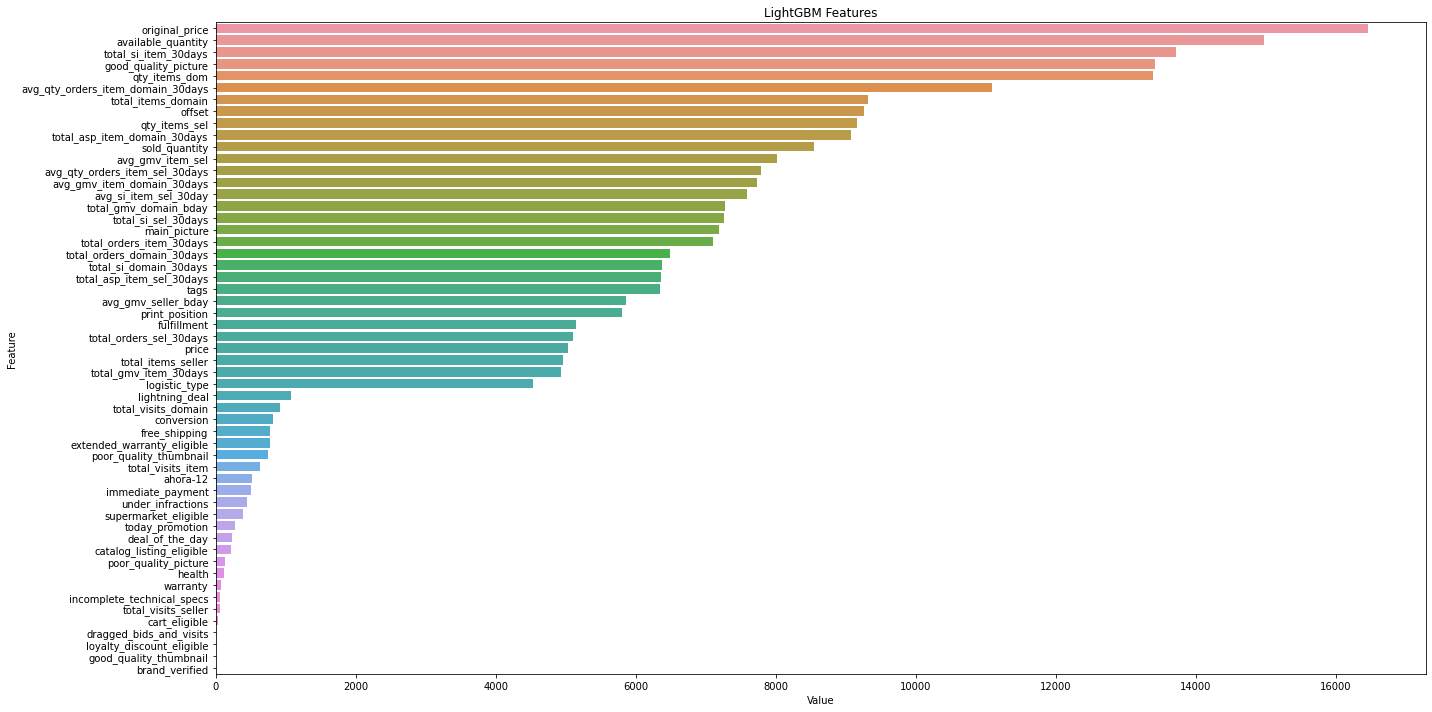

In [81]:
model = learner.model_dict['LGB']['model'][0]
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,df_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sn.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

### Neural Network

#### Preprocessing

In [19]:
def get_dataset(input_scaler, output_scaler, x, x_test, Y, Y_test):
        # scale inputs
    if input_scaler is not None:
      # fit scaler
      input_scaler.fit(x)
      # transform training dataset
      x = input_scaler.transform(x)
      # transform test dataset
      x_test = input_scaler.transform(x_test)
    if output_scaler is not None:
      # reshape 1d arrays to 2d arrays
      Y = Y.values.reshape(len(Y), 1)
      Y_test = Y_test.values.reshape(len(Y_test), 1)
      # fit scaler on training dataset
      output_scaler.fit(Y)
      # transform training dataset
      Y = output_scaler.transform(Y)
      # transform test dataset
      Y_test = output_scaler.transform(Y_test)
    return x, x_test, Y, Y_test

In [22]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = 
get_dataset(MinMaxScaler(), StandardScaler(), X_train, X_test, y_train, y_test)

In [23]:
X_train_f = np.asarray(X_train_scaled).astype('float32')
X_test_f = np.asarray(X_test_scaled).astype('float32')
y_train_f = np.asarray(y_train).astype('float32')
y_test_f = np.asarray(y_test).astype('float32')

#### Modelling

In [44]:
print('Building Neural Network model...')
adam = tf.keras.optimizers.Adam(learning_rate = 0.001, decay = 0.0000001)

model = Sequential()
model.add(Dense(17, input_dim=X_train_f.shape[1],
                kernel_initializer='uniform',
                kernel_regularizer=regularizers.l2(0.1),
                activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(10,
                kernel_regularizer=regularizers.l2(0.1),
                activation="relu"))
model.add(Dense(10,
                kernel_regularizer=regularizers.l2(0.1),
                activation="relu"))
model.add(Dense(10,
                kernel_regularizer=regularizers.l2(0.1),
                activation="relu"))
model.add(Dense(1))
model.add(Activation("sigmoid"))
model.compile(loss='binary_crossentropy', optimizer=SGD(lr=0.0001, momentum=0.9))

history = model.fit(df_X_sampled, df_y_sampled, validation_split=0.2, epochs=20, batch_size=32)


Building Neural Network model...
Epoch 1/20
6561/6561 [==============================] - 14s 2ms/step - loss: 633881024.0000 - val_loss: 130461536.0000
Epoch 2/20
6561/6561 [==============================] - 12s 2ms/step - loss: 46048804.0000 - val_loss: 9408792.0000
Epoch 3/20
6561/6561 [==============================] - 12s 2ms/step - loss: 3321104.5000 - val_loss: 678589.0625
Epoch 4/20
6561/6561 [==============================] - 13s 2ms/step - loss: 239522.7188 - val_loss: 48941.4375
Epoch 5/20
6561/6561 [==============================] - 12s 2ms/step - loss: 17275.2910 - val_loss: 3530.6382
Epoch 6/20
6561/6561 [==============================] - 13s 2ms/step - loss: 1246.5350 - val_loss: 255.5404
Epoch 7/20
6561/6561 [==============================] - 13s 2ms/step - loss: 90.5155 - val_loss: 19.3379
Epoch 8/20
6561/6561 [==============================] - 13s 2ms/step - loss: 7.1419 - val_loss: 2.3037
Epoch 9/20
6561/6561 [==============================] - 12s 2ms/step - loss: 1.1

In [45]:
#Predict on test set
predictions_NN_prob = model.predict(X_test_f)
# predictions_NN_prob = predictions_NN_prob[:,0]
roc_auc_score(y_test_f, predictions_NN_prob)

0.5

In [37]:
recall_score(y_test_f, to_binary(y_test_f, predictions_NN_prob))

100%|██████████| 500/500 [00:09<00:00, 53.90it/s]


1.0

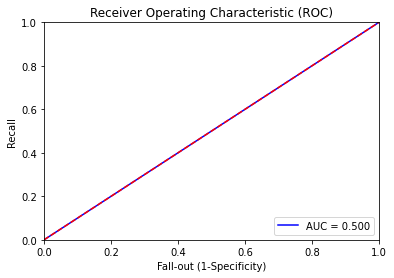

In [49]:
#Print Area Under Curve
false_positive_rate, recall, thresholds = roc_curve(y_test_f, predictions_NN_prob)
roc_auc = auc(false_positive_rate, recall)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

### Model Ensembling

In [113]:
pred_classical = learner.predict(df_test, features, ['LR','LSVC','RF','NB'])

Predicting: 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]


In [114]:
performance(y_test, pred_classical)

Finding the best threshold: 100%|██████████| 500/500 [00:10<00:00, 48.43it/s]


AUC: 0.7080316358378395
Recall: 0.6142131979695431


In [82]:
pred_booster = learner.predict(df_test, features, ['LGB','XGB'])

Predicting: 100%|██████████| 2/2 [00:41<00:00, 20.73s/it]


In [83]:
performance(y_test, pred_booster)

Finding the best threshold: 100%|██████████| 500/500 [00:10<00:00, 48.61it/s]


AUC: 0.780263330266295
Recall: 0.6419826813974321


In [115]:
pred_all = learner.predict(df_test, features, ['LR','LSVC','RF','NB','LGB','XGB'])

Predicting: 100%|██████████| 6/6 [00:41<00:00,  6.94s/it]


In [116]:
performance(y_test, pred_all)

Finding the best threshold: 100%|██████████| 500/500 [00:10<00:00, 48.70it/s]


AUC: 0.7432111828339253
Recall: 0.6010749477455957


### Model Stacking

In [87]:
df_train_stacking = df_train.copy()
df_train_stacking['forecast'] = pred_col

In [88]:
df_test_stacking = df_test.copy()
df_test_stacking['forecast'] = pred_lgb

In [89]:
features_stacking = features.copy()
features_stacking.append('forecast')

In [90]:
stacking_leaner = Learner()

In [108]:
param_xgb={
    'n_estimators':1000,
    'scale_pos_weight':10, 
    'subsample' : 0.8,
    'colsample_bytree': 0.8,
    'learning_rate': 0.09,
    'max_depth': 5
}
stacking_leaner.train(df_test_stacking, target, features_stacking, 5, 'XGB', param_xgb, roc_auc_score)

Training:   0%|          | 0/5 [00:00<?, ?it/s]

[0]	validation_0-auc:0.778968	validation_1-auc:0.770546
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[50]	validation_0-auc:0.835191	validation_1-auc:0.786639
Stopping. Best iteration:
[16]	validation_0-auc:0.807029	validation_1-auc:0.788875



Training:  20%|██        | 1/5 [00:07<00:28,  7.07s/it]

[0]	validation_0-auc:0.780853	validation_1-auc:0.77026
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[50]	validation_0-auc:0.83765	validation_1-auc:0.782945
Stopping. Best iteration:
[18]	validation_0-auc:0.812683	validation_1-auc:0.785105



Training:  40%|████      | 2/5 [00:14<00:21,  7.12s/it]

[0]	validation_0-auc:0.78389	validation_1-auc:0.762395
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[50]	validation_0-auc:0.835268	validation_1-auc:0.775578
Stopping. Best iteration:
[41]	validation_0-auc:0.830257	validation_1-auc:0.776057



Training:  60%|██████    | 3/5 [00:23<00:16,  8.15s/it]

[0]	validation_0-auc:0.788878	validation_1-auc:0.741621
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[50]	validation_0-auc:0.844871	validation_1-auc:0.747968
Stopping. Best iteration:
[38]	validation_0-auc:0.835588	validation_1-auc:0.748576



Training:  80%|████████  | 4/5 [00:32<00:08,  8.56s/it]

[0]	validation_0-auc:0.786343	validation_1-auc:0.75359
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[50]	validation_0-auc:0.83746	validation_1-auc:0.768012
[100]	validation_0-auc:0.868171	validation_1-auc:0.766923
Stopping. Best iteration:
[56]	validation_0-auc:0.841388	validation_1-auc:0.768937



Training: 100%|██████████| 5/5 [00:43<00:00,  8.75s/it]

XGB End of training, avg metric: 0.773510048994074


0.773510048994074

In [109]:
pred_stacking = stacking_leaner.predict(df_test_stacking, features_stacking, ['XGB'])

Predicting: 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


In [110]:
performance(y_test, pred_stacking)

Finding the best threshold: 100%|██████████| 500/500 [00:10<00:00, 49.39it/s]


AUC: 0.8199023242145893
Recall: 0.7832188713048671


### Stepwise regression

In [ ]:
# stepwise selection
def get_auc(predictors, response, data):
    x = data[predictors]
    y = response
    # use lightGBM model to build the model
    model = lgb.LGBMClassifier(
            class_weight="balanced",
            boosting_type='gbdt',
            n_estimators=100)
    model.fit(
        x, 
        y,
        verbose = 50, 
        eval_metric = "auc")
    y_pred = model.predict_proba(X_test[predictors])[:,1]
    result_auc = roc_auc_score(y_test, y_pred)
    return result_auc

def each_step(response, predictors, candidates, data):
    best_auc = -1
    best_candidate = None
    for i in candidates:
        auc_i = get_auc(predictors + [i], response, data)
        if(auc_i > best_auc):
            best_auc = auc_i
            best_candidate = i
    return best_candidate, best_auc

def step_wise(response, features, data):
    current_predictors = []
    best_auc = -1
    candidates = features.copy()
    for i in features:
        best = each_step(response, current_predictors, candidates, data)
        print(best[0])
        print(best[1])
        if(best[1] <= best_auc):
            return current_predictors, best_auc
        best_auc = best[1]
        current_predictors = current_predictors + [best[0]]
        candidates.remove(best[0])
    return current_predictors, best_auc


In [ ]:
step_wise(df_train[target], features, df_train)

In [ ]:

selected_predictors = ['print_position',
  'total_orders_item_30days',
  'total_asp_item_domain_30days',
  'offset',
  'price',
  'total_asp_item_sel_30days',
  'avg_qty_orders_item_domain_30days',
  'cart_eligible',
  'total_visits_domain',
  'discount',
  'health',
  'poor_quality_picture',
  'qty_items_sel',
  'free_shipping',
  'under_infractions']